In [37]:
import torch
import argparse
from data_gen.data_set import message_gen, channel_set_gen
from training.train import test_training
from training.test import test_per_channel_per_snr
from nets.auto_encoder import dnn
from torch.utils.tensorboard import SummaryWriter
from nets.auto_encoder_for_vis import dnn_vis
from training.meta_train import multi_task_learning
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import numpy
import os

In [38]:
parser = argparse.ArgumentParser(description='end_to_end-meta')

# bit num (k), channel uses (n), tap number (L), number of pilots (P), Eb/N0
parser.add_argument('--bit_num', type=int, default=4, help='number of bits')
parser.add_argument('--channel_num', type=int, default=4, help='number of channel uses')
parser.add_argument('--tap_num', type=int, default=3, help='..')
parser.add_argument('--mb_size', type=int, default=16, help='minibatch size')
parser.add_argument('--mb_size_meta_train', type=int, default=16,
                    help='minibatch size during meta-training (this can be useful for decreasing pilots)')
parser.add_argument('--mb_size_meta_test', type=int, default=16,
                    help='minibatch size for query set (this can be useful for decreasing pilots)')
parser.add_argument('--Eb_over_N_db', type=float, default=15,
                    help='energy per bit to noise power spectral density ratio')

# paths
parser.add_argument('--path_for_common_dir', dest='path_for_common_dir',
                    default='default_folder/default_subfolder/', type=str)
parser.add_argument('--path_for_meta_training_channels', dest='path_for_meta_training_channels', default=None,
                    type=str)
parser.add_argument('--path_for_test_channels', dest='path_for_test_channels', default=None, type=str)
parser.add_argument('--path_for_meta_trained_net', dest='path_for_meta_trained_net', default=None, type=str)

# neural network architecture (number of neurons for hidden layer)
parser.add_argument('--num_neurons_encoder', type=int, default=None, help='number of neuron in hidden layer in encoder')
parser.add_argument('--num_neurons_decoder', type=int, default=None, help='number of neuron in hidden layer in decoder')
# whether to use bias and relu (if not relu: tanh)
parser.add_argument('--if_not_bias', dest='if_bias', action='store_false', default=True)
parser.add_argument('--if_not_relu', dest='if_relu', action='store_false', default=True)
# RTN
parser.add_argument('--if_RTN', dest='if_RTN', action='store_true', default=False)
# in case of running on gpu, index for cuda device
parser.add_argument('--cuda_ind', type=int, default=0, help='index for cuda device')

# experiment details (hyperparameters, number of data for calculating performance and for meta-training
parser.add_argument('--lr_testtraining', type=float, default=0.001, help='lr for adaptation to new channel')
parser.add_argument('--lr_meta_update', type=float, default=0.01, help='lr during meta-training: outer loop (update initialization) lr')
parser.add_argument('--lr_meta_inner', type=float, default=0.1, help='lr during meta-training: inner loop (local adaptation) lr')
parser.add_argument('--test_size', type=int, default=1000000, help='number of messages to calculate BLER for test (new channel)')
parser.add_argument('--num_channels_meta', type=int, default=100, help='number of meta-training channels (K)')
parser.add_argument('--num_channels_test', type=int, default=20, help='number of new channels for test (to get average over BLER)')
parser.add_argument('--tasks_per_metaupdate', type=int, default=20, help='number of meta-training channels considered in one meta-update')
parser.add_argument('--num_meta_local_updates', type=int, default=1, help='number of local adaptation in meta-training')
parser.add_argument('--num_epochs_meta_train', type=int, default=10000,
                    help='number epochs for meta-training')

# if run for joint training, if false: meta-learning
parser.add_argument('--if_joint_training', dest='if_joint_training', action='store_true', default=False) # else: meta-learning for multi-task learning
# whether to use Adam optimizer to adapt to a new channel
parser.add_argument('--if_not_test_training_adam', dest='if_test_training_adam', action='store_false',
                    default=True)
# if run on toy example (Fig. 2 and 3)
parser.add_argument('--if_toy', dest='if_toy', action='store_true',
                    default=False)
# to run on a more realistic example (Fig. 4)
parser.add_argument('--if_RBF', dest='if_RBF', action='store_true',
                    default=False)
parser.add_argument('--test_per_adapt_fixed_Eb_over_N_value', type=int, default=15,
                    help='Eb/N0 in db for test')
# desinged for maml: sgd during args.num_meta_local_updates with args.lr_meta_inner and then follow Adam optimizer with args.lr_testtraining
parser.add_argument('--if_adam_after_sgd', dest='if_adam_after_sgd', action='store_true',
                    default=False)

_StoreTrueAction(option_strings=['--if_adam_after_sgd'], dest='if_adam_after_sgd', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [39]:
# common setting for toy
run_script = "--if_toy --num_epochs_meta_train 0 --path_for_common_dir toy/jupyter/"


In [40]:
if __name__ == '__main__':
    args = parser.parse_args(run_script.split())
    args.device = torch.device("cuda:" + str(args.cuda_ind) if torch.cuda.is_available() else "cpu")
    if args.num_neurons_encoder == None: # unless specified, set number of hidden neurons to be same as the number of possible messages
        args.num_neurons_encoder = pow(2,args.bit_num)
    if args.num_neurons_decoder == None:
        args.num_neurons_decoder = pow(2, args.bit_num)

    if args.if_test_training_adam == False:
        args.if_adam_after_sgd = False

    if args.if_toy == True:
        print('running for toy scenario')
        args.bit_num = 2
        args.channel_num = 1
        args.tap_num = 1
        args.mb_size = 4
        args.mb_size_meta_train = 4
        args.mb_size_meta_test = 4
        args.num_channels_meta = 20
        args.num_neurons_encoder = 4
        args.num_neurons_decoder = 4
    elif args.if_RBF == True:
        print('running for a more realistic scenario')
        args.bit_num = 4
        args.channel_num = 4
        args.tap_num = 3
        args.mb_size = 16
        args.mb_size_meta_train = 16
        args.mb_size_meta_test = 16
        args.num_channels_meta = 100
        args.num_neurons_encoder = 16
        args.num_neurons_decoder = 16
    else:
        print('running on custom environment')
    print('Running on device: {}'.format(args.device))

running for toy scenario
Running on device: cuda:0


In [41]:
    curr_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    common_dir = './' + args.path_for_common_dir + curr_time + '/'

    PATH_before_adapt = common_dir + 'saved_model/' + 'before_adapt/' + 'init_net'
    PATH_meta_intermediate = common_dir + 'saved_model/' + 'during_meta_training/' + 'epochs/'

    os.makedirs(common_dir + 'saved_model/' + 'before_adapt/')
    os.makedirs(common_dir + 'saved_model/' + 'after_adapt/')
    os.makedirs(PATH_meta_intermediate)

    os.makedirs(common_dir + 'meta_training_channels/')
    os.makedirs(common_dir + 'test_channels/')
    os.makedirs(common_dir + 'test_result/')

    dir_meta_training = common_dir + 'TB/' + 'meta_training'
    writer_meta_training = SummaryWriter(dir_meta_training)
    dir_during_adapt = common_dir + 'TB/' + 'during_adapt/'

    test_Eb_over_N_range = [args.test_per_adapt_fixed_Eb_over_N_value]
    test_adapt_range = [0, 1, 2, 5, 10, 100, 200, 1000, 10000]

    if len(test_Eb_over_N_range) > 1:
        assert len(test_adapt_range) == 1
    if len(test_adapt_range) > 1:
        assert len(test_Eb_over_N_range) == 1

    test_result_all_PATH = common_dir + 'test_result/' + 'test_result.mat'
    save_test_result_dict = {}

    actual_channel_num = args.channel_num * 2

    net = dnn(M=pow(2, args.bit_num), num_neurons_encoder=args.num_neurons_encoder, n=actual_channel_num, n_inv_filter = args.tap_num,
              num_neurons_decoder=args.num_neurons_decoder, if_bias=args.if_bias, if_relu=args.if_relu, if_RTN=args.if_RTN)
    if torch.cuda.is_available():
        net = net.to(args.device)
    net_for_testtraining = dnn(M=pow(2, args.bit_num), num_neurons_encoder=args.num_neurons_encoder, n=actual_channel_num, n_inv_filter = args.tap_num,
              num_neurons_decoder=args.num_neurons_decoder, if_bias=args.if_bias, if_relu=args.if_relu, if_RTN=args.if_RTN)
    if torch.cuda.is_available():
        net_for_testtraining = net_for_testtraining.to(args.device)
    net_for_vis = dnn(M=pow(2, args.bit_num), num_neurons_encoder=args.num_neurons_encoder, n=actual_channel_num,
              n_inv_filter = args.tap_num,
              num_neurons_decoder=args.num_neurons_decoder, if_bias=args.if_bias,
              if_relu=args.if_relu, if_RTN=args.if_RTN)
    if torch.cuda.is_available():
        net_for_vis = net_for_vis.to(args.device)

    Eb_over_N = pow(10, (args.Eb_over_N_db/10))
    R = args.bit_num/args.channel_num
    noise_var = 1 / (2 * R * Eb_over_N)
    Noise = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(actual_channel_num), noise_var * torch.eye(actual_channel_num))
    if args.path_for_meta_training_channels is None:
        print('generate meta-training channels')
        h_list_meta = channel_set_gen(args.num_channels_meta, args.tap_num, args.if_toy)
        h_list_meta_path = common_dir + 'meta_training_channels/' + 'training_channels.pckl'
        f_meta_channels = open(h_list_meta_path, 'wb')
        pickle.dump(h_list_meta, f_meta_channels)
        f_meta_channels.close()
    else:
        print('load previously generated channels')
        h_list_meta_path = args.path_for_meta_training_channels + '/' + 'training_channels.pckl'
        f_meta_channels = open(h_list_meta_path, 'rb')
        h_list_meta = pickle.load(f_meta_channels)
        f_meta_channels.close()

    if args.path_for_meta_trained_net is None:
        if args.if_joint_training:
            print('start joint training')
        else:
            print('start meta-training')
        multi_task_learning(args, net, h_list_meta, writer_meta_training, Noise)
        torch.save(net.state_dict(), PATH_before_adapt)
    else:
        PATH_before_adapt = args.path_for_meta_trained_net

    if args.path_for_test_channels is None:
        print('generate test channels')
        h_list_test = channel_set_gen(args.num_channels_test, args.tap_num, args.if_toy)
        h_list_test_path = common_dir + 'test_channels/' + 'test_channels.pckl'
        f_test_channels = open(h_list_test_path, 'wb')
        pickle.dump(h_list_test, f_test_channels)
        f_test_channels.close()
    else:
        print('load previously generated channels')
        h_list_test_path = args.path_for_test_channels + '/' + 'test_channels.pckl'
        f_test_channels = open(h_list_test_path, 'rb')
        h_list_test = pickle.load(f_test_channels)
        f_test_channels.close()

    if len(h_list_test) > args.num_channels_test:
        h_list_test = h_list_test[:args.num_channels_test]
    print('used test channels', h_list_test)

generate meta-training channels
start meta-training
generate test channels
used test channels [tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071]), tensor([0.7071, 0.7071]), tensor([-0.7071,  0.7071])]


In [152]:
num_adapt = 1 # training iteration number
ind_channel = 0 # index of channel (wheter phase pi/4 (even idx) or 3pi/4 (odd idx))
if_RTN = False # need to change this in order to switch between vanilla (False) and autoencoder with RTN (True)

In [153]:
### vanilla
# meta
PATH_before_adapt_meta_vanilla = 'saved_data/toy/nets/vanilla/meta/init_net'
PATH_after_adapt_meta_vanilla = 'saved_data/toy/after_adapted_to_new_channels_nets/vanilla/meta/after_adapt/' + str(num_adapt) + '_adapt_steps/' + str(ind_channel) + 'th_adapted_net' 

### with rtn
# meta
PATH_before_adapt_meta_rtn = 'saved_data/toy/nets/with_RTN/meta/init_net'
PATH_after_adapt_meta_rtn = 'saved_data/toy/after_adapted_to_new_channels_nets/with_RTN/meta/after_adapt/' + str(num_adapt) + '_adapt_steps/' + str(ind_channel) + 'th_adapted_net' 


In [154]:
# choose appropriate path for visualization
current_PATH = PATH_before_adapt_meta_vanilla
#current_PATH = PATH_after_adapt_meta_vanilla
#current_PATH = PATH_before_adapt_meta_rtn
#current_PATH = PATH_after_adapt_meta_rtn
 
net_for_vis = dnn_vis(M=pow(2, args.bit_num), num_neurons_encoder=args.num_neurons_encoder, n=actual_channel_num, n_inv_filter = args.tap_num,
              num_neurons_decoder=args.num_neurons_decoder, if_bias=args.if_bias, if_relu=args.if_relu, if_RTN=if_RTN)
if torch.cuda.is_available():
    net_for_vis = net_for_vis.to(args.device)


In [155]:
# load saved autoencoder
net_for_vis.load_state_dict(torch.load(current_PATH))


<All keys matched successfully>

In [156]:
def message_gen_tmp(k, mb_size):
    tot_message_num = pow(2,k)
    m = torch.zeros(mb_size, tot_message_num)
    label = torch.zeros(mb_size)
    for ind_mb in range(mb_size):
        if ind_mb % tot_message_num == 0:
            pass
            #rand_lst = torch.randperm(tot_message_num) # remove randomness for simpleness.
        ind_one_rand_lst = ind_mb % tot_message_num
        ind_one = ind_one_rand_lst
        m[ind_mb, ind_one] = 1
        label[ind_mb] = ind_one
    return m, label

In [157]:
# visualizing constellation points

num_datapoints_transmitted = 1000
h = h_list_test[ind_channel]
artificial_input = None # for decision region, now should be None
m_test, label_test = message_gen_tmp(args.bit_num, num_datapoints_transmitted)
m_test = m_test.type(torch.FloatTensor).to(args.device)
label_test = label_test.type(torch.LongTensor).to(args.device)
net_for_vis.zero_grad()
out_test, modulated_symbol, received_signal = net_for_vis(m_test, h, Noise, args.device,if_RTN, artificial_input)


In [158]:
print('h', h)
modulated_symbol = modulated_symbol.data.cpu().numpy()
m_test = m_test.data.cpu().numpy()
received_signal = received_signal.data.cpu().numpy()

h tensor([0.7071, 0.7071])


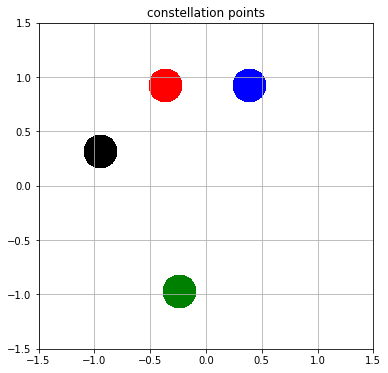

In [159]:

fig, ax = plt.subplots(figsize=(6,6))
xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
color_list = ['r', 'g', 'b', 'k']
for j in range(num_datapoints_transmitted):
    c_ind = j%4
    ax.scatter(modulated_symbol[j,0], modulated_symbol[j,1], c=color_list[c_ind], label = m_test[c_ind], s = 1000)
ax.grid(True)
plt.title('constellation points')
plt.show()


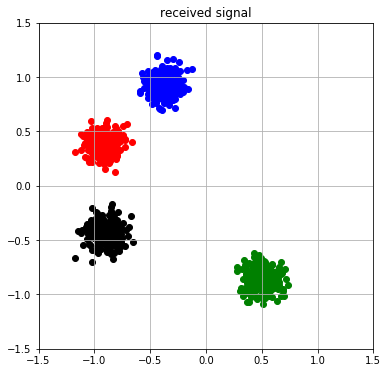

In [160]:
fig, ax = plt.subplots(figsize=(6,6))
xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
color_list = ['r', 'g', 'b', 'k']
for j in range(num_datapoints_transmitted):
    c_ind = j%4
    ax.scatter(received_signal[j,0], received_signal[j,1], c=color_list[c_ind], label = m_test[c_ind])
ax.grid(True)
plt.title('received signal')
plt.show()


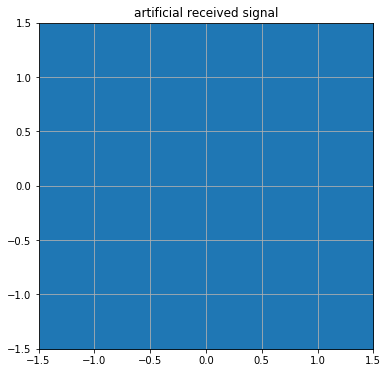

In [161]:
# generating artificial recieved signal for visualizing decision region
num_data_points = 100
artificial_input = torch.zeros(num_data_points*num_data_points,2)

real_min = -1.5
real_max = 1.5
im_min = -1.5
im_max = 1.5

for real_input in range(num_data_points):
    for im_input in range(num_data_points):
        artificial_input[real_input*num_data_points+im_input,0] = ((real_max-real_min)/(num_data_points-1)) * real_input + real_min
        artificial_input[real_input*num_data_points+im_input,1] = ((im_max-im_min)/(num_data_points-1)) * im_input + im_min
fig, ax = plt.subplots(figsize=(6,6))
xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.scatter(artificial_input[:,0], artificial_input[:,1])
plt.title('artificial received signal')
ax.grid(True)
plt.show()

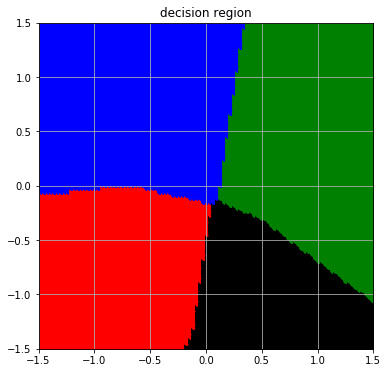

In [162]:
fig, ax = plt.subplots(figsize=(6,6))
xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

artificial_input = artificial_input.type(torch.FloatTensor).to(args.device)

m_test, label_test = message_gen_tmp(args.bit_num, num_data_points*num_data_points)
m_test = m_test.type(torch.FloatTensor).to(args.device)
label_test = label_test.type(torch.LongTensor).to(args.device)
out_test, modulated_symbol, received_signal = net_for_vis(m_test, h, Noise, args.device, if_RTN, artificial_input)
artificial_input = artificial_input.data.cpu().numpy()
color_list = ['r', 'g', 'b', 'k']
for ind_datapoints in range(num_data_points*num_data_points):
    ind_max = torch.argmax(out_test[ind_datapoints]).data.cpu().numpy()
    ax.scatter(artificial_input[ind_datapoints, 0], artificial_input[ind_datapoints, 1], c=color_list[ind_max], label = m_ref[ind_max])
plt.title('decision region')
ax.grid(True)
plt.show()